# Download all documents

In [1]:
import pandas as pd
import requests
import json
MY_API_KEY = 'e3fd43198781e92e0e07b7f543064003'
univs = {
    'Charles University':60016605,
    'Central European University':60009563,
    'New Economic School in Moscow':60027279,
    'University of Warsaw':60013756,
    'University of Vienna':60025988,
    'Stockholm University':60028378,
    'tilburg University':60017145,
    'KU Leuven':60025063
}

def processLink(sLink,dfs):
    dfs.append(pd.DataFrame(d['entry']))

    
def getAPIresponse(sLink):
    r = requests.get(sLink,headers={'Accept':'application/json','X-ELS-APIKey': MY_API_KEY})
    return r.json()['search-results']
    
def entriesToDF(d,key):
    df = pd.DataFrame(d['entry'])
    df['Institution'] = key
    return df
    
def processQuery(dfs,link,key):   
    d = getAPIresponse(link)
    dfs.append(entriesToDF(d,key))
    
    links = {link['@ref']:link['@href'] for link in d['link']}
    
    if 'next' in links:
        #dfs.append(processLink(links['next']))
        nextLink = links['next']
    else: 
        nextLink = ''
    return dfs,nextLink

def processInst(key):
    nextLink = "http://api.elsevier.com/content/search/scopus?query=AF-ID%28{}%29%20AND%20PUBYEAR%20%3E%202013%20AND%20SUBJAREA%28ECON%29&count=25".format(univs[key])
    
    dfs = []
    while nextLink != '':
        dfs,nextLink = processQuery(dfs,nextLink,key)
    
    return pd.concat(dfs)
    
dfs = []

for key in univs:
    dfs.append(processInst(key))

df = pd.concat(dfs)


# Download journals data

In [2]:
issns = df['prism:issn'].dropna().unique()
l = []
for issn in issns:
    r = requests.get('https://api.elsevier.com/content/serial/title/issn/{}?apiKey=e3fd43198781e92e0e07b7f543064003'.format(issn)).json()
    if 'serial-metadata-response' in r.keys():
        d = r['serial-metadata-response']['entry'][0]
        hasSJR = 'SJRList' in d
        hasSNIP = 'SNIPList' in d
        
        if (hasSJR and hasSNIP):
            l.append({'issn':issn,
                      'SJR':d['SJRList']['SJR'][0]['$'],
                      'SJRyear':d['SJRList']['SJR'][0]['@year'],
                      'SNIP':d['SNIPList']['SNIP'][0]['$'],
                      'SNIPyear':d['SNIPList']['SNIP'][0]['@year']
                     })
        elif (hasSJR and not hasSNIP):
            l.append({'issn':issn,
                      'SJR':d['SJRList']['SJR'][0]['$'],
                      'SJRyear':d['SJRList']['SJR'][0]['@year']
                     })
        elif (hasSNIP and not hasSJR):
            l.append({'issn':issn,
                      'SNIP':d['SNIPList']['SNIP'][0]['$'],
                      'SNIPyear':d['SNIPList']['SNIP'][0]['@year']
                     })


journals = pd.DataFrame(l)

# Merge and sort

In [15]:
merged = df.merge(journals,left_on='prism:issn',right_on='issn',how='inner')

sort = {
    'Charles University':0,
    'Central European University':1,
    'New Economic School in Moscow':2,
    'University of Warsaw':3,
    'University of Vienna':4,
    'Stockholm University':5,
    'tilburg University':6,
    'KU Leuven':7
}
merged['Sorter'] = merged.Institution.map(sort)
merged = merged.sort_values('Sorter',ascending=True)


merged.SJR = merged.SJR.astype('float64')
merged.SNIP = merged.SNIP.astype('float64')
merged['citedby-count'] = merged['citedby-count'].astype('float64')

merged.loc[merged.SJR > 10,'SJR'] = 10
merged.loc[merged.SNIP > 10,'SNIP'] = 10


%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def histVar(df,var,density):
    g = sns.FacetGrid(df,col='Institution', palette='Set1',col_wrap=3) 
    g.map(plt.hist,var,**{'bins':20,'density':density,'range':(0,10)})


# SJR (relative counts)

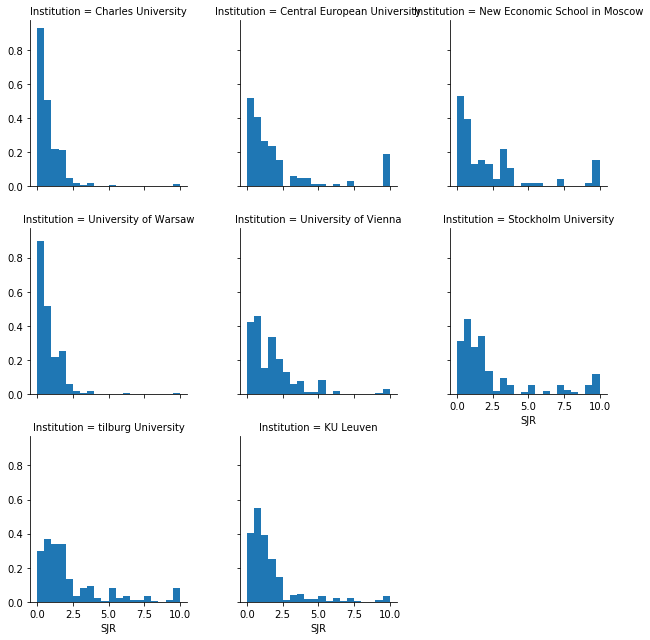

In [16]:
histVar(merged,'SJR',True)

# SJR (absolute counts)

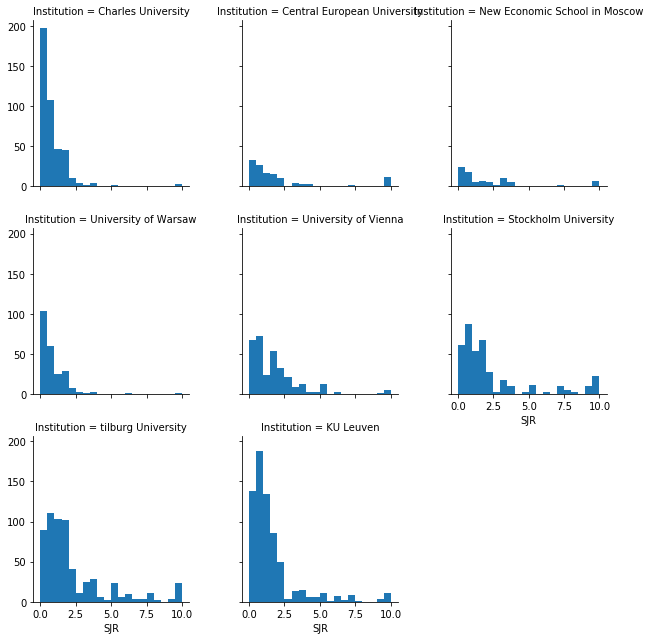

In [17]:
histVar(merged,'SJR',False)

# SNIP (relative counts)

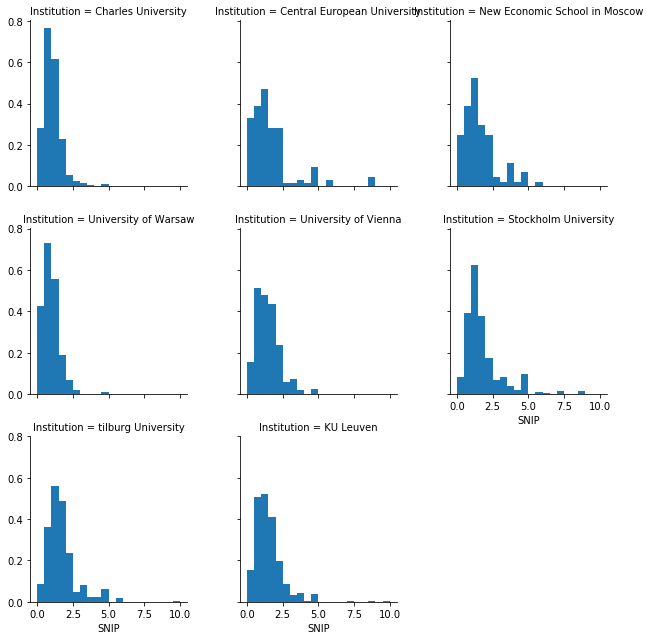

In [18]:
histVar(merged,'SNIP',True)

# SNIP (absolute count)

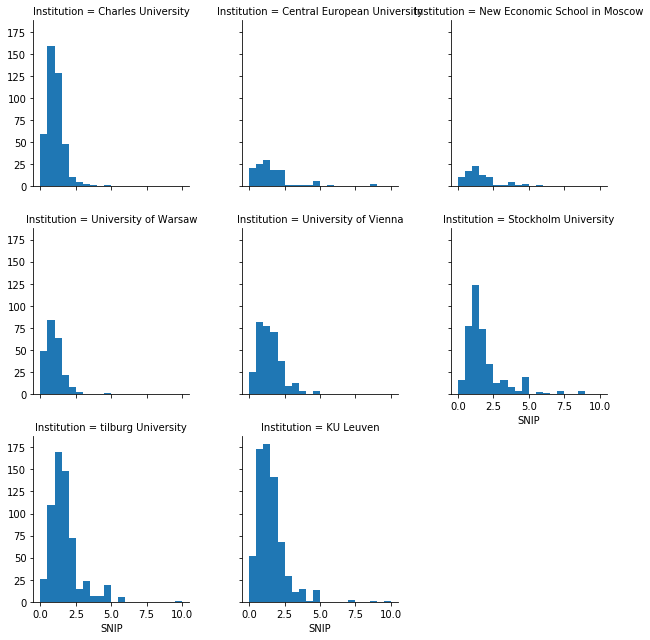

In [19]:
histVar(merged,'SNIP',False)